# Fair Value Gap Up - Analytics

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
data.tail(20)

,Open,High,Low,Close,Volume
Date,,,,,
2025-10-21 11:25:00,1868.6,1875.9,1865.0,1873.0,5958
2025-10-21 13:00:00,1873.6,1883.0,1873.0,1877.7,8695
2025-10-21 13:05:00,1877.8,1885.8,1877.8,1881.2,6718
2025-10-21 13:10:00,1881.4,1884.8,1878.3,1884.5,5454
2025-10-21 13:15:00,1884.5,1900.0,1884.5,1899.9,16683
2025-10-21 13:20:00,1899.9,1906.0,1892.6,1894.9,14956
2025-10-21 13:25:00,1894.9,1902.9,1889.2,1899.2,10721
2025-10-21 13:30:00,1899.2,1903.2,1892.0,1897.6,9370
2025-10-21 13:35:00,1898.0,1904.9,1896.4,1902.4,9267


In [5]:
data["fvg_up"] = (data["High"].shift(2) < data["Low"])

In [6]:
%%time
data['long_return'] = None
data['short_return'] = None
for i, row in data.iterrows():
    if row['fvg_up']:
        current_date = row.name.strftime('%Y-%m-%d ').format()
        current_time = row.name
        entry_price = row['Close']
        data_to_end_day = data[(data.index > current_time) & (data.index < current_date+' 14:30:00')]
        max_price = entry_price
        min_price = entry_price
        for k, wrow in data_to_end_day.iterrows():
            if wrow['Low'] < min_price:
                min_price = wrow['Low']
            if wrow['High'] > max_price:
                max_price = wrow['High']
            long_return = max_price - entry_price
            short_return = entry_price - min_price
        data.at[i, 'long_return'] = long_return
        data.at[i, 'short_return'] = short_return

CPU times: user 27.2 s, sys: 19.9 ms, total: 27.2 s
Wall time: 27.3 s


## Phân tích mối quan hệ Return và ATR & RSI

In [7]:
df1 = data[["Open", "Close", "High", "Low", "fvg_up", "long_return", "short_return"]].copy()
df1["long_return"] = df1["long_return"].astype(float)
df1["short_return"] = df1["short_return"].astype(float)
df1["RSI_14"] = ta.rsi(df1["Close"], length=14)
df1["ATR_14"] = ta.atr(high=df1["High"], low=df1["Low"], close=df1["Close"], length=14)
df1.dropna(inplace=True)
df1["RSI_14"] = round(df1["RSI_14"], 1)
df1["ATR_14"] = round(df1["ATR_14"], 1)

In [8]:
df1['rsi_group'] = pd.qcut(df1.RSI_14, 20)
df1['atr_group'] = pd.qcut(df1.ATR_14, 20)

In [9]:
fvg_df = df1[df1.fvg_up == True]
long_group = fvg_df.groupby(['rsi_group', 'atr_group'])[['long_return']]
short_group = fvg_df.groupby(['rsi_group', 'atr_group'])[['short_return']]

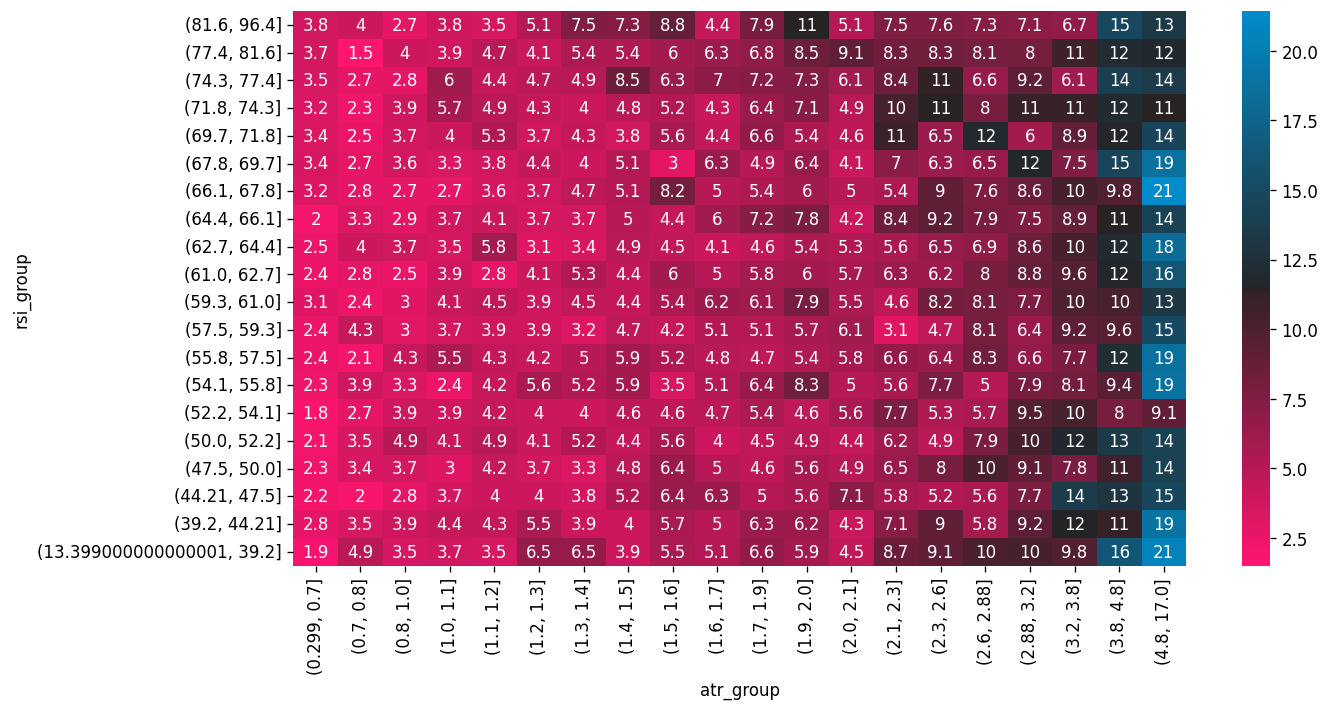

In [11]:
irs1 = long_group.mean().reset_index()
irs_pivot1 = irs1.pivot(index='rsi_group', columns='atr_group', values='long_return').sort_index(ascending=False)
sns.heatmap(
    irs_pivot1,
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True);

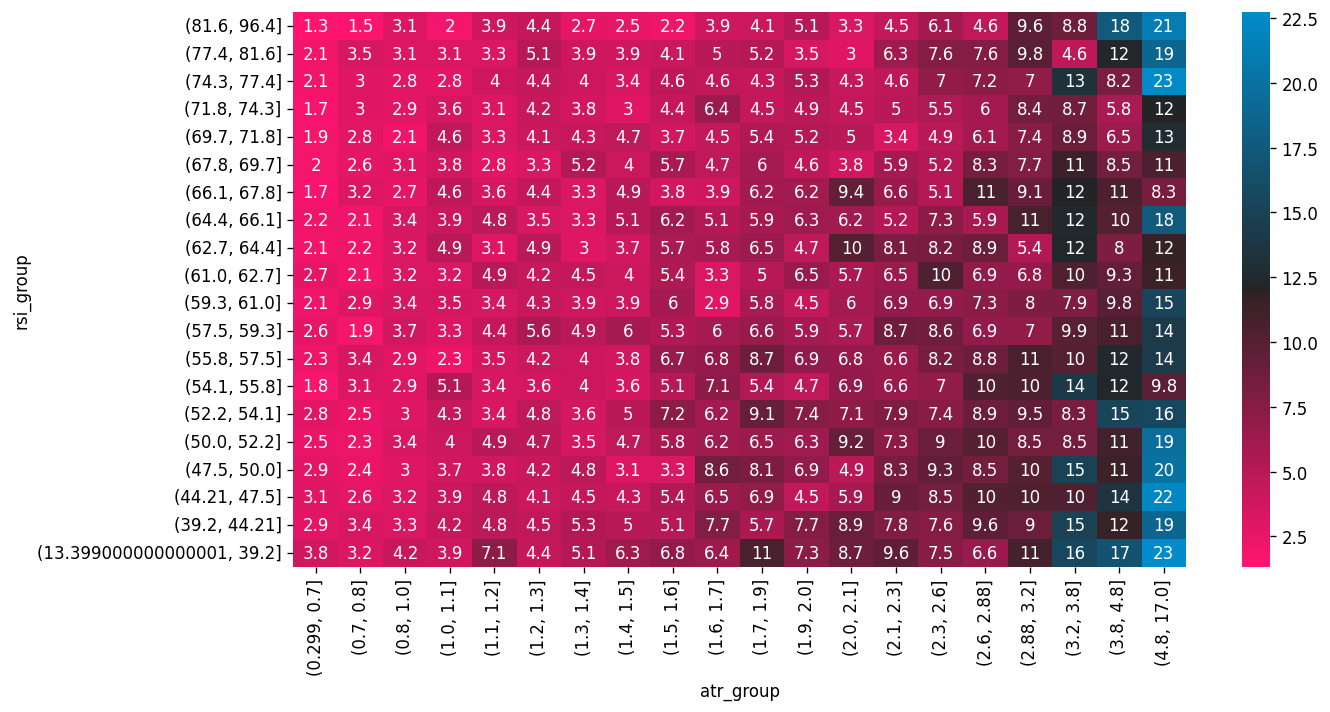

In [12]:
irs2 = short_group.mean().reset_index()
irs_pivot2 = irs2.pivot(index='rsi_group', columns='atr_group', values='short_return').sort_index(ascending=False)
sns.heatmap(
    irs_pivot2,
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True);

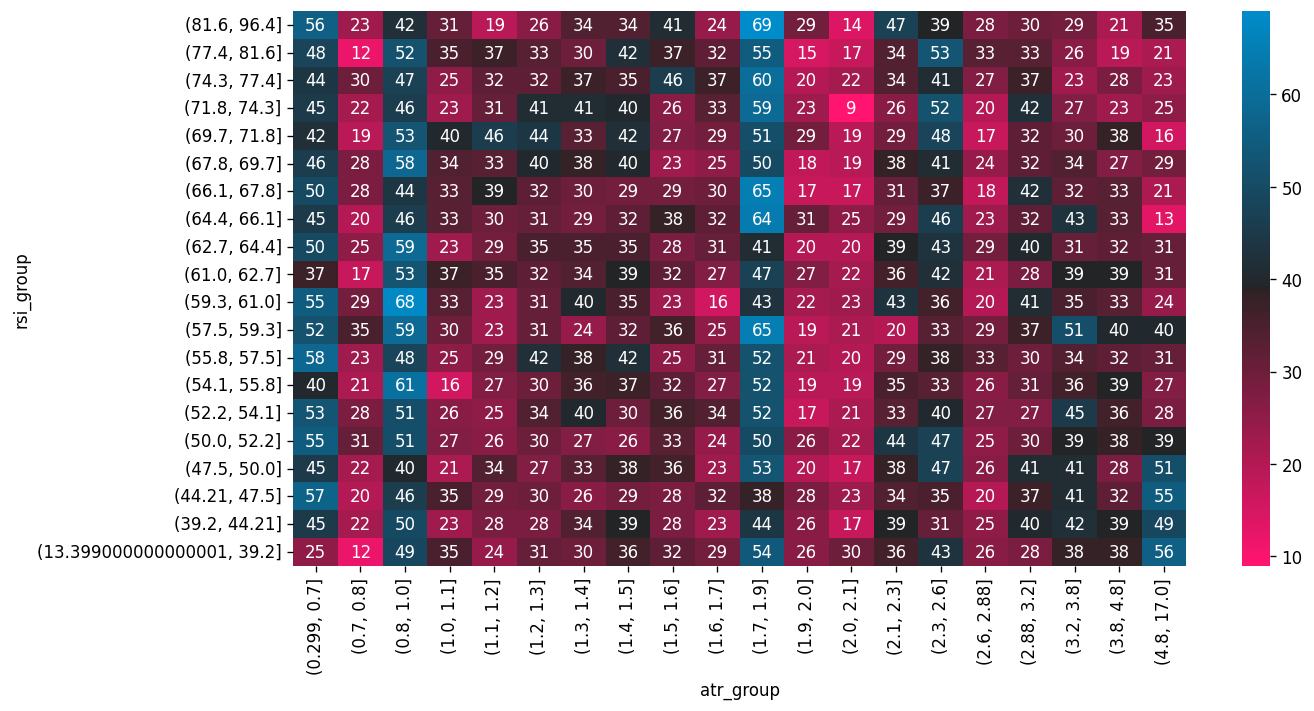

In [13]:
irs3 = long_group.count().reset_index()
irs_pivot3 = irs3.pivot(index='rsi_group', columns='atr_group', values='long_return').sort_index(ascending=False)
sns.heatmap(
    irs_pivot3,
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True);

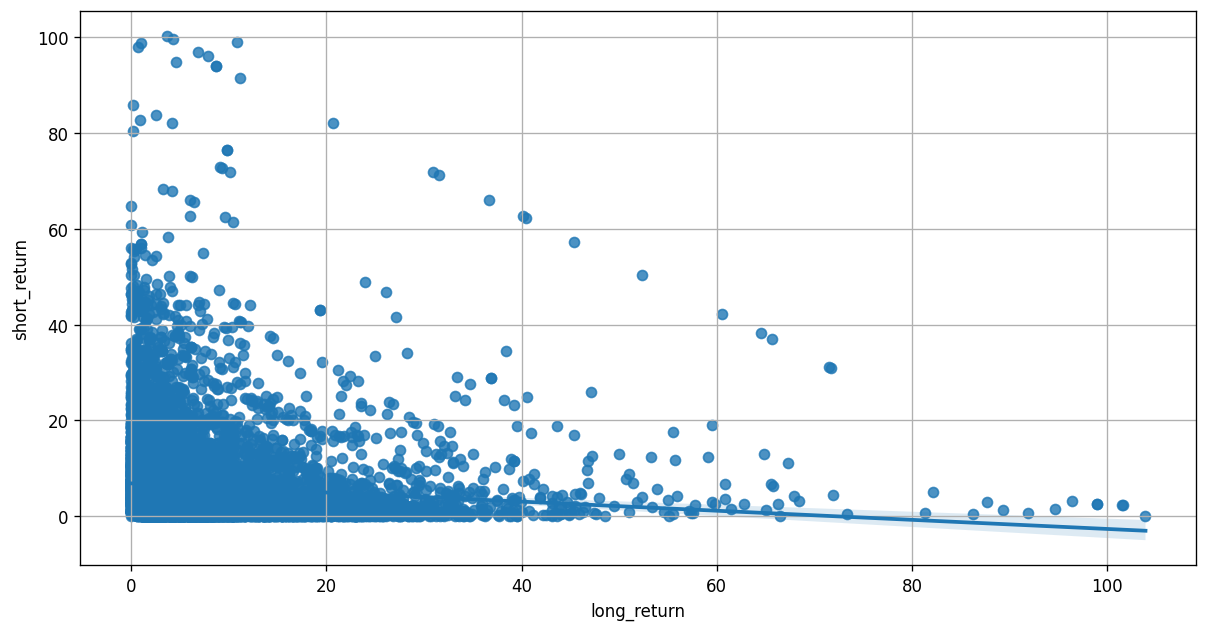

In [15]:
sns.regplot(x=fvg_df['long_return'], y=fvg_df['short_return'])
plt.grid(True)